# Model 1: Carbon in the continenetal crust extracted from the atmosphere

In [2]:
%pylab inline

# Import libraries
from ipywidgets import widgets, IntSlider, Label
from IPython.display import display

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def plot_models(t, solution):
    plt.rc('text', usetex=True)
    
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(14,18), sharex=False)
    
    ax1.plot(t, solution[:,0], label='Atmosphere')
    ax1.plot(t, solution[:,1], label='Continental Crust')
    ax1.plot(t, solution[:,2], label='Mantle')
    
    ax1.set_xlabel(r't (Gyr)', fontsize='xx-large')
    ax1.set_ylabel(r'$^cM \times 10^8$ Gt', fontsize='xx-large')
    ax1.set_yticklabels([0.0, 0.0, 0.25, 0.5, 0.75, 1.0,1.25, 1.5, 1.75,2.0], fontsize='xx-large')
    for label in ax1.get_xticklabels()[1::2]:
        label.set_visible(False)
    for label in ax1.get_yticklabels()[::2]:
        label.set_visible(False)
    for label in ax1.get_xticklabels()[::2]:
        label.set_fontsize('xx-large')   
    ax1.legend(loc='center left', ncol=1, fancybox=True, shadow=True, fontsize='xx-large')

    ax2.plot(t, solution[:,0], label='Atmosphere')
    ax2.set_xlabel(r't (Gyr)', fontsize='xx-large')
    ax2.set_ylabel(r'$^cM$ Gt', fontsize='xx-large')
    for label in ax2.get_xticklabels()[::2]:
        label.set_visible(False)
    for label in ax2.get_xticklabels()[1::2]:
        label.set_fontsize('xx-large')
    for label in ax2.get_yticklabels()[::2]:
        label.set_visible(False)
    for label in ax2.get_yticklabels()[1::2]:
        label.set_fontsize('xx-large')    
    ax2.set_xlim([2,4.4])
    ax2.set_ylim([0,3000])
    ax2.legend(loc='center right', ncol=1, fancybox=True, shadow=True, fontsize='xx-large')

    savefig('Model_1_A-cc_plot.pdf', format='pdf')
    plt.show()

41998000.000000134
200000000.0000005


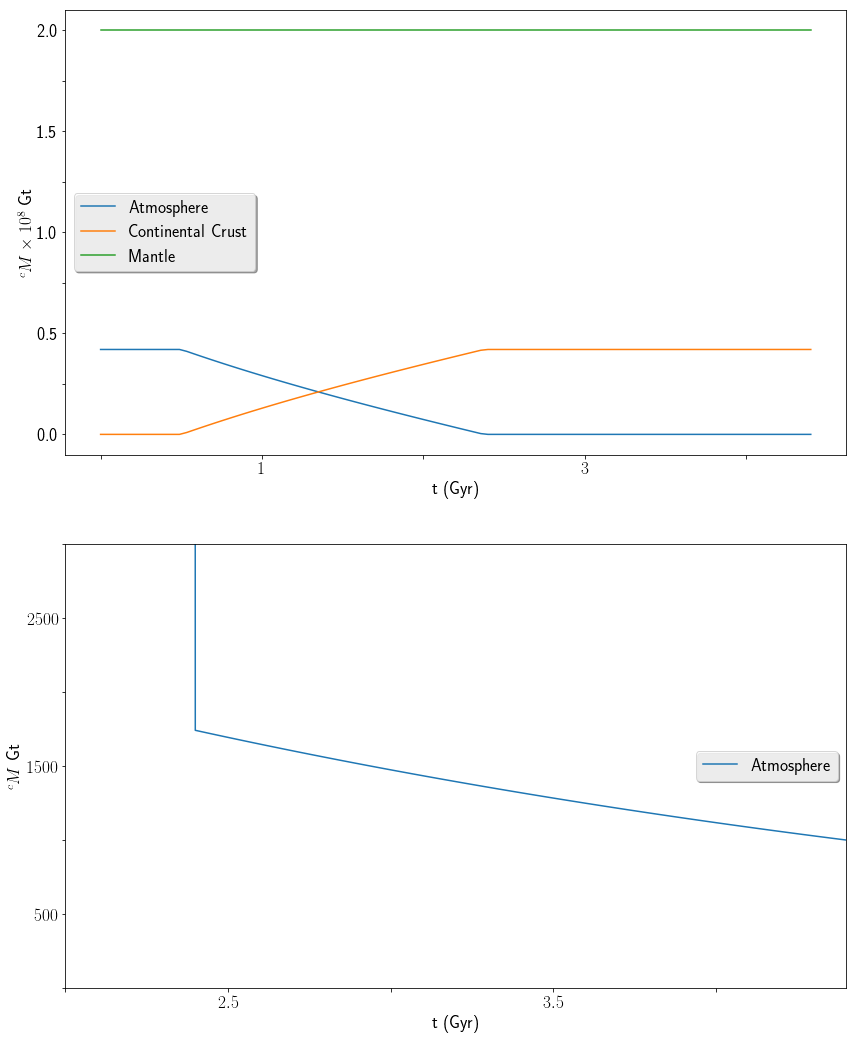

In [4]:
def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, tau_acc, cMa0, cMmp, cFmap, cMccp, cFccmp, cFccap = params
    
    if (t == t_2):
        cMa = cMa_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [0,
                  0,
                  0]
    else:
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1 + (cMcc/cMccp)*cFccap*exp((t_p - t)/tf),
                  cMa0/tau_1 - (cMcc/cMccp)*cFccap*exp((t_p - t)/tf) - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]

    return derivs

def g(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, tau_acc, cMa0, cMa_t2, cMcc_t2, cMm_t2, cMmp, cFmap, cMccp, cFccmp, cFccap = params
    
    if (t == t_2):
        cMa = cMa_t2
        cMcc = cMcc_t2
        cMm = cMm_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [0,
                  0,
                  0]
    elif (t_1 <= t and t < t_2):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1 + (cMcc/cMccp)*cFccap*exp((t_p - t)/tf),
                  cMa0/tau_1 - (cMcc/cMccp)*cFccap*exp((t_p - t)/tf) - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [(cMcc/cMccp)*cFccap*exp((t_p - t)/tf) - cMa/tau_acc,
                 cMa/tau_acc - (cMcc/cMccp)*cFccap*exp((t_p - t)/tf),
                 0]

    return derivs

def assemble_solve_ode(cMa0, cFccmp):
    # Parameters
    t_0 = 0   #Gyr
    t_1 = 0.5 #Gyr
    t_p = 4.4  #Gyr

    tau_1 = 1.5 #Gyr
    tau_acc = 2e5/1e9 #Gyr
    t_2 = 2.1 #bogus value, reset by interpolant
    tf = 3.61
    ts = 1e2

    cFmap = (0/1000)*1e9 #Gt/Gyr
    cMmp = 1.15e8
    cFccmp = (0/1000)*1e9 #Gt/Gyr
    cMccp = 4.2e7
    # Updated 5 Mt/yr
    cFccap = (5/1000)*1e9 #Gt/Gyr

    # Initial values
    cMcc0 = 0
    cMm0 = 2.0e8 #Gt

    # Bundle parameters for ODE solver
    params = [t_0, t_1, t_2, t_p, tf, tau_1, tau_acc, cMa0, cMmp, cFmap, cMccp, cFccmp, cFccap]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    t = np.linspace(t_0,t_p,ts)
    solution = odeint(f, y0, t, args=(params,))
    
    solution_interpolant = interp1d(t, solution[:,0], 'cubic')
    
    cMa_t2 = 2000 #Gt
    t_2, = fsolve(lambda t: cMa_t2 - solution_interpolant(t), 2)
#     print(t_2)
#     print(solution_interpolant(t_2))

    # Bundle parameters for ODE solver
    solution_interpolant_cMcc = interp1d(t, solution[:,1], 'cubic')
    solution_interpolant_cMm = interp1d(t, solution[:,2], 'cubic')
    cMcc_t2 = solution_interpolant_cMcc(t_2)
    cMm_t2 = solution_interpolant_cMm(t_2)
#     print(cMcc_t2)
#     print(cMm_t2)
    
    # Rebundle parameters for ODE solver with intial conditions at time t2
    params = [t_0, t_1, t_2, t_p, tf, tau_1, tau_acc, cMa0, cMa_t2, cMcc_t2, cMm_t2, cMmp, cFmap, cMccp, cFccmp, cFccap]
    solution = odeint(g, y0, t, args=(params,))
    
    plot_models(t, solution)
    return solution

       
sol = assemble_solve_ode(0.42e8, 0)
# print(sol[:,0][-1])
# print(sol[:,1][-1])
# print(sol[:,2][-1])
